# Laboratorium 5

In [45]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [83]:
def variance(probe, mean):
    return np.sum((probe - mean)**2) / (len(probe) - 1)

In [35]:
def d(S0, T, K, sigma, r, sign):
    return (np.log(S0/K) + (r + sign * sigma**2 / 2)*T)/(sigma * np.sqrt(T))

In [36]:
def theoretical_price(S0, T, K, sigma, r):
    return S0 * norm.cdf(d(S0, T, K, sigma, r, 1))  - K*np.exp(-r*T) * norm.cdf(d(S0, T, K, sigma, r, -1))

In [40]:
im = theoretical_price(100, 1, 80, 1, 0.1)
print(f'Cena opcji call In The Money: {im:.2f}')
om = theoretical_price(100, 1, 120, 1, 0.1)
print(f'Cena opcji call Out Of The Money: {om:.2f}')

Cena opcji call In The Money: 48.37
Cena opcji call Out Of The Money: 35.77


## Zadanie 1
a) Monte Carlo

In [71]:
def get_ST(S0, T, sigma, r, n):
    X = np.random.normal(0, 1, n)
    X = sigma*np.sqrt(T)*X + (r - sigma**2 / 2)*T
    return S0 * np.exp(X)

In [104]:
def Monte_Carlo(S0, T, sigma, r, K, n=10**7):
    ST = get_ST(S0, T, sigma, r, n)
    probe = np.exp(-r*T) * np.maximum(ST - K, [0])
    prices = np.cumsum(probe) / np.arange(1, n+1)
    var = variance(probe, prices[-1])
    return prices[10**4:n], var

In [105]:
prices, var = Monte_Carlo(100, 1, 1, 0.1, 80)

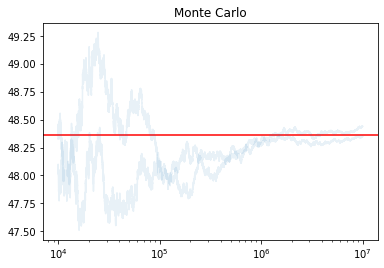

In [112]:
plt.axhline(y=im, color='r', linestyle='-')
for i in range(2):
    prices, _ = Monte_Carlo(100, 1, 1, 0.1, 80)
    plt.plot(np.arange(10**4, 10**4 + len(prices)), prices, color='C0', alpha=0.1)
plt.xscale('log')
plt.title('Monte Carlo')
plt.show()